In [1]:
import numpy as np

import jax
from jax import random, numpy as jnp
from jax.nn.initializers import he_normal
import flax
from flax import linen as nn
from typing import Sequence, Any
from flax.training import train_state
import optax

from functools import partial
import matplotlib.pyplot as plt

In [6]:
class FFNN(nn.Module):
    features: Sequence[int]
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, t, x, train: bool = True):
        x = jnp.concatenate((t, x), axis=-1)
        for idx, out_feat in enumerate(self.features):
            x = nn.BatchNorm(use_running_average=not train,
                   momentum=0.9,
                   epsilon=1e-5,
                   dtype=self.dtype)(x)
            x = nn.Dense(features=out_feat)(x)
            if idx != len(self.features) - 1:
                x = nn.relu(x)
        return x

In [7]:
S0 = 100
exercise_price = 100
sigma = 0.4
r = 0.03
dividend = 0.00
tau = 3 # T, total 3 years
M = 500 # S
N = 600 # t
Smax = 500
is_call = True
N_b = 100 # boundary
N_exp = 1000 # expiration
N_f = 10000 # collocation
lb = [0, 0]
ub = [500, tau] #upper limit for S and T
t, S = jnp.meshgrid(jnp.linspace(0, 1, N+1), jnp.linspace(0, Smax, M+1)) # generate grid

In [8]:
def initialize_data(N_b, N_exp, N_f, lb, ub, exercise_price, tau):
    data = dict()

    # data for collocation
    data['col'] = dict()
    data['col']['t'] = jnp.array(random.randint(random.PRNGKey(0), minval = 0, maxval = 100 * ub[1] + 1, shape = (N_f, 1)) / 100, dtype=jnp.float32)
    data['col']['x'] = jnp.array(random.randint(random.PRNGKey(0), minval = 0, maxval = ub[0] + 1, shape = (N_f, 1)), dtype=jnp.float32)
    data['col']['f'] = jnp.zeros(shape=(N_f, 1))

    data['b'] = dict()
    # data for boundary u(t, x=0) = 0
    stock_0_t = jnp.array(random.randint(random.PRNGKey(10), minval = 1, maxval = 100 * ub[1] + 1, shape = (N_b, 1)) / 100, dtype=jnp.float32)
    stock_0_x = jnp.zeros(shape=(N_b, 1), dtype=jnp.float32)
    stock_0_u = jnp.zeros(shape=(N_b, 1), dtype=jnp.float32)
    
    # data for expire time
    t_exp_t = jnp.zeros(shape=(N_exp, 1), dtype=jnp.float32) + tau
    t_exp_x = jnp.array(random.randint(random.PRNGKey(20), minval = 0, maxval = ub[0] + 1, shape = (N_exp, 1)), dtype=jnp.float32)
    t_exp_u = jnp.maximum(t_exp_x - exercise_price, 0)

    data['b']['t'] = jnp.concatenate([stock_0_t, t_exp_t])
    data['b']['x'] = jnp.concatenate([stock_0_x, t_exp_x])
    data['b']['u'] = jnp.concatenate([stock_0_u, t_exp_u])
    
    return data

data = initialize_data(N_b, N_exp, N_f, lb, ub, exercise_price, tau)

In [9]:
class TrainState(train_state.TrainState):
    batch_stats: flax.core.FrozenDict[str, Any] = None

model = FFNN(features=[50, 50, 50, 50, 50, 50, 50, 50, 50, 1])
# model = FFNN(features=[10, 1])
rng = random.PRNGKey(0)
variables = model.init(rng, jnp.ones([200, 1]), jnp.ones([200, 1]))

learning_rate = 8e-3

tx = optax.adam(learning_rate=learning_rate)

if 'batch_stats' in variables:
    state = TrainState.create(
        apply_fn=model.apply,
        params=variables['params'],
        tx=tx,
        batch_stats=variables['batch_stats'],
    )
else:
    state = TrainState.create(
        apply_fn=model.apply,
        params=variables['params'],
        tx=tx,
    )

In [10]:
@jax.jit
def mse_loss(u, u_pred):
    return jnp.mean(jnp.square(u - u_pred))

def train_step(state, data, sigma, r):
    x_col = data['col']['x']
    t_col = data['col']['t']
    f_col = data['col']['f']

    x_b = data['b']['x']
    t_b = data['b']['t']
    u_b = data['b']['u']
    

    def forward_fn(params, t, x):
        u = state.apply_fn({'params': params, 'batch_stats': state.batch_stats}, t, x, train=False)
        # u = state.apply_fn({'params': params}, t, x, train=False)
        return u

    def pinn_loss(params):
        @partial(jax.vmap, in_axes=(0, 0))
        def equation_output(t, x):
            u = forward_fn(params, t, x)
            # u, new_model_state = state.apply_fn(
            #     {'params': params, 'batch_stats': state.batch_stats}, 
            #     t, x,
            #     mutable=['batch_stats'])
            # u = state.apply_fn(
            #     {'params': params}, 
            #     t, x)
            u_x, u_t = jax.jacrev(forward_fn, argnums=(1, 2))(params, t, x)
            u_xx = jax.jacrev(jax.jacrev(forward_fn, argnums=2), argnums=2)(params, t, x)
            equation = u_t + 0.5 * (sigma ** 2) * (x ** 2) * u_xx + r * x * u_x - r * u 
            return equation
        
        _, new_model_state = state.apply_fn(
                {'params': params, 'batch_stats': state.batch_stats}, 
                t_col, x_col,
                mutable=['batch_stats'])

        pred_f = equation_output(t_col, x_col)
        # loss_u = jnp.mean((u_pred - boundary_target) ** 2)
        loss_f = mse_loss(pred_f, f_col)

        pred_b = forward_fn(params, t_b, x_b)
        loss_b = mse_loss(pred_b, u_b)
        # loss = loss_f
        loss = loss_f + loss_b

        return loss, new_model_state
    
    (loss, model_state), grads = jax.value_and_grad(
        pinn_loss, has_aux=True)(state.params)
    
    # print(state.batch_stats)

    new_state = state.apply_gradients(
      grads=grads,
      batch_stats=model_state['batch_stats'],
    )

    # print(model_state['batch_stats'])
    
    return new_state, loss


In [12]:
MAX_EPOCHS = 700
pinn_loss_history = []
for i in range(MAX_EPOCHS):
    rng, _ = jax.random.split(rng)

    perms_col = jax.random.permutation(rng, len(data['col']['t']))
    perms_b = jax.random.permutation(rng, len(data['b']['t']))

    data['col']['t'] = data['col']['t'][perms_col]
    data['col']['x'] = data['col']['x'][perms_col]
    data['col']['f'] = data['col']['f'][perms_col]

    data['b']['t'] = data['b']['t'][perms_b]
    data['b']['x'] = data['b']['x'][perms_b]
    data['b']['u'] = data['b']['u'][perms_b]
    
    
    state, l = train_step(state, data, sigma, r)

    pinn_loss_history.append(l)

print(np.array(pinn_loss_history))


[5.32634668e+03 5.37148779e+03 5.32602686e+03 5.46850293e+03
 5.79644141e+03 6.05546924e+03 6.34550928e+03 6.49429199e+03
 6.79942480e+03 7.21754736e+03 7.61114404e+03 7.85566602e+03
 8.11332812e+03 8.25966504e+03 8.53376758e+03 8.72582617e+03
 8.80215234e+03 8.84310547e+03 8.84041309e+03 8.74978809e+03
 8.88993457e+03 9.14301367e+03 8.87909375e+03 8.90715527e+03
 9.02728613e+03 8.80637891e+03 8.73039844e+03 8.77337500e+03
 8.76383105e+03 8.72365137e+03 8.63799023e+03 8.55847070e+03
 8.47298633e+03 8.44822461e+03 8.36418066e+03 8.29758301e+03
 8.23667578e+03 8.11269189e+03 7.99739551e+03 7.90097900e+03
 7.81284229e+03 7.78239648e+03 7.62338281e+03 7.51740967e+03
 7.41966602e+03 7.22658691e+03 7.10834180e+03 7.13304688e+03
 6.93055762e+03 7.06784570e+03 6.72997168e+03 6.58743164e+03
 6.49669727e+03 6.35637402e+03 6.22422266e+03 6.26602539e+03
 6.09990576e+03 6.05471387e+03 5.90094189e+03 5.64152295e+03
 5.59804736e+03 5.52076709e+03 5.38548193e+03 5.24380762e+03
 5.16231738e+03 5.174880

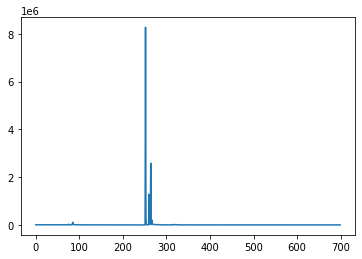

In [13]:
plt.plot(range(0, MAX_EPOCHS), pinn_loss_history)